In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pybedtools as pbt
from scipy import stats
import numpy as np
from statannotations.Annotator import Annotator

In [45]:
#Output location
figures = "../../results/fig/"

In [46]:
# Input
DATA = "../../data/"
dnase_reddington = DATA + "DNase-seq_Reddington2020/DHS_clusters_dm6.gff"

#read contact positions located in significant bin pairs
significant_pairs = pd.read_csv("../../results/csv/WE_positions_std.csv", sep = "\t")
significant_pairs.head()

,chrom,pos1,strand1,h1,pos2,strand2,h2,transh,pos1-1,pos2-1,interactionID,replicate,dist,bin_name1,bin_name2,bin pair type,std1,std2,num_contacts
0,chr2L,10000460,+,DGRP-57,10002717,-,DGRP-57,False,10000459,10002716,93553,Rep1,2257,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210
1,chr2L,10000646,DGRP-57,DGRP-57,10003143,DGRP-57,DGRP-57,False,10000645,10003142,158488,Rep1,2497,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210
2,chr2L,10001136,DGRP-57,DGRP-57,10004253,DGRP-57,DGRP-57,False,10001135,10004252,186509,Rep1,3117,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210
3,chr2L,10000483,-,DGRP-57,10003916,+,DGRP-57,False,10000482,10003915,448998,Rep1,3433,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210
4,chr2L,10002350,DGRP-57,DGRP-57,10004194,DGRP-57,DGRP-57,False,10002349,10004193,901009,Rep1,1844,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210


In [47]:
significant_pairs["bin pair type"] = significant_pairs["bin pair type"].apply(lambda x: {"transDOWN" : "transh-down", "transUP" : "transh-up"}[x])

In [48]:
len(significant_pairs)

447044

In [49]:
len(significant_pairs["interactionID"].unique())

439733

In [50]:
significant_pairs[significant_pairs["interactionID"]==5451004]

,chrom,pos1,strand1,h1,pos2,strand2,h2,transh,pos1-1,pos2-1,interactionID,replicate,dist,bin_name1,bin_name2,bin pair type,std1,std2,num_contacts
2901,chr2L,10447827,DGRP-439,DGRP-439,10458366,DGRP-439,DGRP-439,False,10447826,10458365,5451004,Rep2,10539,chr2L:10447500-10450000,chr2L:10457500-10460000,transh-down,495.81418,744.387677,94
4543,chr2L,10522617,DGRP-439,DGRP-439,10527795,DGRP-439,DGRP-439,False,10522616,10527794,5451004,Rep1,5178,chr2L:10522500-10525000,chr2L:10527500-10530000,transh-down,527.70896,772.266122,70


In [51]:
#read significant DESeq results
significant = pd.read_csv("../../results/csv/WE_diff_bin_pairs.csv", sep = "\t", index_col = 0)
significant.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DGRP-57_locus1_chr2L:10000000-10002500_chr2L:10002500-10005000,11.328060,-3.026789,1.058510,-2.859482,0.004243,0.045783
DGRP-57_locus1_chr2L:10025000-10027500_chr2L:10027500-10030000,4.884034,-4.421116,1.483977,-2.979234,0.002890,0.044235
DGRP-57_locus1_chr2L:10190000-10192500_chr2L:10197500-10200000,3.908042,-4.106179,1.494520,-2.747490,0.006005,0.046718
DGRP-57_locus1_chr2L:10210000-10212500_chr2L:10217500-10220000,3.973403,-4.134231,1.499326,-2.757392,0.005826,0.046499
DGRP-57_locus1_chr2L:10212500-10215000_chr2L:10215000-10217500,11.605186,-2.394369,0.878435,-2.725720,0.006416,0.046838


In [52]:
len(significant)

6889

In [53]:
def find_affected_locus(row):
    '''
    Add info about affected locus and allele based on bin pair name.
    
    *Affected locus* is not the one mentioned in the name because
    the name points to the locus were the haplotype is common for cish
    and transh interactions.
    
    *Affected allele/haplotype* is the one in the comparison name
    because transh interactions link the haplotype from the name
    with the other haplotype. If they dominate then the haplotype
    from the name is depleted in cish interactions.
    '''
    
    affected_allele = row.name.split("_")[0]
    
    if row.name.split("_")[1] == "locus1":
        unaffected_locus = row["bin_name1"]
        affected_locus = row["bin_name2"]
        affected_locus_num = 2
    elif row.name.split("_")[1] == "locus2":
        affected_locus = row["bin_name1"]
        unaffected_locus = row["bin_name2"]
        affected_locus_num = 1
    else:
        print(row.name.split("_")[1])
        
    if row["log2FoldChange"] > 0:
        direction = "UP"
    elif row["log2FoldChange"] < 0:
        direction = "DOWN"
    
    row["affected_allele"] = affected_allele
    row["affected_locus_num"] = affected_locus_num
    row["affected_locus_coordinates"] = affected_locus
    row["direction"] = direction
    
    return row

In [54]:
significant["bin_name1"] = "chr" + significant.index.str.split("_chr").str[1]
significant["bin_name2"] = "chr" + significant.index.str.split("_chr").str[2]
significant = significant.apply(find_affected_locus, axis=1)
significant.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bin_name1,bin_name2,affected_allele,affected_locus_num,affected_locus_coordinates,direction
DGRP-57_locus1_chr2L:10000000-10002500_chr2L:10002500-10005000,11.328060,-3.026789,1.058510,-2.859482,0.004243,0.045783,chr2L:10000000-10002500,chr2L:10002500-10005000,DGRP-57,2,chr2L:10002500-10005000,DOWN
DGRP-57_locus1_chr2L:10025000-10027500_chr2L:10027500-10030000,4.884034,-4.421116,1.483977,-2.979234,0.002890,0.044235,chr2L:10025000-10027500,chr2L:10027500-10030000,DGRP-57,2,chr2L:10027500-10030000,DOWN
DGRP-57_locus1_chr2L:10190000-10192500_chr2L:10197500-10200000,3.908042,-4.106179,1.494520,-2.747490,0.006005,0.046718,chr2L:10190000-10192500,chr2L:10197500-10200000,DGRP-57,2,chr2L:10197500-10200000,DOWN
DGRP-57_locus1_chr2L:10210000-10212500_chr2L:10217500-10220000,3.973403,-4.134231,1.499326,-2.757392,0.005826,0.046499,chr2L:10210000-10212500,chr2L:10217500-10220000,DGRP-57,2,chr2L:10217500-10220000,DOWN
DGRP-57_locus1_chr2L:10212500-10215000_chr2L:10215000-10217500,11.605186,-2.394369,0.878435,-2.725720,0.006416,0.046838,chr2L:10212500-10215000,chr2L:10215000-10217500,DGRP-57,2,chr2L:10215000-10217500,DOWN


In [55]:
significant.tail()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bin_name1,bin_name2,affected_allele,affected_locus_num,affected_locus_coordinates,direction
DGRP-439_locus2_chr3R:6205000-6207500_chr3R:25795000-25797500,7.431712,7.747887,1.527165,5.073380,3.908120e-07,1.281123e-04,chr3R:6205000-6207500,chr3R:25795000-25797500,DGRP-439,1,chr3R:6205000-6207500,UP
DGRP-439_locus2_chr3R:8040000-8042500_chr3R:21727500-21730000,88.776282,11.325244,1.468487,7.712184,1.236831e-14,1.737677e-11,chr3R:8040000-8042500,chr3R:21727500-21730000,DGRP-439,1,chr3R:8040000-8042500,UP
DGRP-439_locus2_chr3R:8040000-8042500_chr3R:21730000-21732500,46.998142,10.409973,1.466466,7.098681,1.259533e-12,1.376334e-09,chr3R:8040000-8042500,chr3R:21730000-21732500,DGRP-439,1,chr3R:8040000-8042500,UP
DGRP-439_locus2_chrX:10970000-10972500_chrX:15780000-15782500,6.206967,7.485402,1.541108,4.857157,1.190835e-06,2.898857e-04,chrX:10970000-10972500,chrX:15780000-15782500,DGRP-439,1,chrX:10970000-10972500,UP
DGRP-439_locus2_chrX:3307500-3310000_chrX:15510000-15512500,31.550092,9.834824,1.471694,6.682657,2.346489e-11,2.097889e-08,chrX:3307500-3310000,chrX:15510000-15512500,DGRP-439,1,chrX:3307500-3310000,UP


In [56]:
#to add affected allele and locus to the df with contact positions I merge the two dfs based on bin coordinates.
significant_pairs = pd.merge(significant_pairs, significant[["bin_name1", "bin_name2", "affected_allele", "affected_locus_num"]],
                             on = ["bin_name1", "bin_name2"], how="left")

In [57]:
significant_pairs.head()

,chrom,pos1,strand1,h1,pos2,strand2,h2,transh,pos1-1,pos2-1,...,replicate,dist,bin_name1,bin_name2,bin pair type,std1,std2,num_contacts,affected_allele,affected_locus_num
0,chr2L,10000460,+,DGRP-57,10002717,-,DGRP-57,False,10000459,10002716,...,Rep1,2257,chr2L:10000000-10002500,chr2L:10002500-10005000,transh-down,732.88617,639.025214,210,DGRP-57,2
1,chr2L,10000646,DGRP-57,DGRP-57,10003143,DGRP-57,DGRP-57,False,10000645,10003142,...,Rep1,2497,chr2L:10000000-10002500,chr2L:10002500-10005000,transh-down,732.88617,639.025214,210,DGRP-57,2
2,chr2L,10001136,DGRP-57,DGRP-57,10004253,DGRP-57,DGRP-57,False,10001135,10004252,...,Rep1,3117,chr2L:10000000-10002500,chr2L:10002500-10005000,transh-down,732.88617,639.025214,210,DGRP-57,2
3,chr2L,10000483,-,DGRP-57,10003916,+,DGRP-57,False,10000482,10003915,...,Rep1,3433,chr2L:10000000-10002500,chr2L:10002500-10005000,transh-down,732.88617,639.025214,210,DGRP-57,2
4,chr2L,10002350,DGRP-57,DGRP-57,10004194,DGRP-57,DGRP-57,False,10002349,10004193,...,Rep1,1844,chr2L:10000000-10002500,chr2L:10002500-10005000,transh-down,732.88617,639.025214,210,DGRP-57,2


In [58]:
len(significant_pairs)

930820

In [59]:
significant_pairs[significant_pairs["interactionID"]==7930293]

,chrom,pos1,strand1,h1,pos2,strand2,h2,transh,pos1-1,pos2-1,...,replicate,dist,bin_name1,bin_name2,bin pair type,std1,std2,num_contacts,affected_allele,affected_locus_num
930812,chrX,9870708,DGRP-439,DGRP-439,10262608,DGRP-57,DGRP-57,True,9870707,10262607,...,Rep1,391900,chrX:9870000-9872500,chrX:10262500-10265000,transh-up,97.032921,17.146428,7,DGRP-57,1
930813,chrX,9870708,DGRP-439,DGRP-439,10262608,DGRP-57,DGRP-57,True,9870707,10262607,...,Rep1,391900,chrX:9870000-9872500,chrX:10262500-10265000,transh-up,97.032921,17.146428,7,DGRP-439,2


In [60]:
significant_pairs.columns

Index(['chrom', 'pos1', 'strand1', 'h1', 'pos2', 'strand2', 'h2', 'transh',
       'pos1-1', 'pos2-1', 'interactionID', 'replicate', 'dist', 'bin_name1',
       'bin_name2', 'bin pair type', 'std1', 'std2', 'num_contacts',
       'affected_allele', 'affected_locus_num'],
      dtype='object')

To be able to annotate each position from the contact with the distance to DNase peak separately I will transform the df to the long format. To do so I create two dfs: one with annotated positions 1, the second with annotated positions 2, and concat them.

In [61]:
significant_pairs_locus1 = significant_pairs[["chrom", "pos1", "strand1", "h1", "transh", "pos1-1", 'interactionID', 'replicate', 'bin_name1', 'bin pair type', 'affected_allele', 'affected_locus_num']].copy()
significant_pairs_locus1["locus"] = 1
significant_pairs_locus1 = significant_pairs_locus1.rename(columns = {"pos1":"pos", "strand1":"strand", "h1":"h", "pos1-1":"pos-1", 'bin_name1':"bin_name"})
significant_pairs_locus1.head()

,chrom,pos,strand,h,transh,pos-1,interactionID,replicate,bin_name,bin pair type,affected_allele,affected_locus_num,locus
0,chr2L,10000460,+,DGRP-57,False,10000459,93553,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1
1,chr2L,10000646,DGRP-57,DGRP-57,False,10000645,158488,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1
2,chr2L,10001136,DGRP-57,DGRP-57,False,10001135,186509,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1
3,chr2L,10000483,-,DGRP-57,False,10000482,448998,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1
4,chr2L,10002350,DGRP-57,DGRP-57,False,10002349,901009,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1


In [62]:
significant_pairs_locus2 = significant_pairs[["chrom", "pos2", "strand2", "h2", "transh", "pos2-1", 'interactionID', 'replicate', 'bin_name2', 'bin pair type', 'affected_allele', 'affected_locus_num']].copy()
significant_pairs_locus2["locus"] = 2
significant_pairs_locus2 = significant_pairs_locus2.rename(columns = {"pos2":"pos", "strand2":"strand", "h2":"h", "pos2-1":"pos-1", 'bin_name2':"bin_name"})
significant_pairs_locus2.head()

,chrom,pos,strand,h,transh,pos-1,interactionID,replicate,bin_name,bin pair type,affected_allele,affected_locus_num,locus
0,chr2L,10002717,-,DGRP-57,False,10002716,93553,Rep1,chr2L:10002500-10005000,transh-down,DGRP-57,2,2
1,chr2L,10003143,DGRP-57,DGRP-57,False,10003142,158488,Rep1,chr2L:10002500-10005000,transh-down,DGRP-57,2,2
2,chr2L,10004253,DGRP-57,DGRP-57,False,10004252,186509,Rep1,chr2L:10002500-10005000,transh-down,DGRP-57,2,2
3,chr2L,10003916,+,DGRP-57,False,10003915,448998,Rep1,chr2L:10002500-10005000,transh-down,DGRP-57,2,2
4,chr2L,10004194,DGRP-57,DGRP-57,False,10004193,901009,Rep1,chr2L:10002500-10005000,transh-down,DGRP-57,2,2


In [63]:
significant_pairs_long = pd.concat([significant_pairs_locus1, significant_pairs_locus2])

In [64]:
len(significant_pairs_long)

1861640

I will remove transh contact positions if they are located in the unaffected locus. To do this I keep contacts which are NOT (transh & locus == affected_locus).

In [65]:
significant_pairs_long_filtered = significant_pairs_long[~((significant_pairs_long["transh"] == True) & (significant_pairs_long["affected_locus_num"] != significant_pairs_long["locus"]))].copy()
significant_pairs_long_filtered.head()

,chrom,pos,strand,h,transh,pos-1,interactionID,replicate,bin_name,bin pair type,affected_allele,affected_locus_num,locus
0,chr2L,10000460,+,DGRP-57,False,10000459,93553,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1
1,chr2L,10000646,DGRP-57,DGRP-57,False,10000645,158488,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1
2,chr2L,10001136,DGRP-57,DGRP-57,False,10001135,186509,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1
3,chr2L,10000483,-,DGRP-57,False,10000482,448998,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1
4,chr2L,10002350,DGRP-57,DGRP-57,False,10002349,901009,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1


In [66]:
len(significant_pairs_long_filtered)

1833276

I would like to be able to check if haplotype influences distance to the DNase peak so I add a specific column which will allow me for plotting haplotypes separately. For cish interactions I just keep the haplotype - this is simple. For transh interactions I assign the haplotype which is affected.

In [67]:
def assign_haplotype_for_dnase(row):
    '''
    For cish just assign the haplotype of the first position
    For transh assign the affected haplotype
    '''
    if row["transh"] == False:
        haplotype_for_dnase = row["h"] + "_cish"
    else:
        haplotype_for_dnase = row["affected_allele"] + "_transh"

    return haplotype_for_dnase            

In [68]:
significant_pairs_long_filtered["haplotype"] = significant_pairs_long_filtered.apply(assign_haplotype_for_dnase, axis=1)
significant_pairs_long_filtered.head()

,chrom,pos,strand,h,transh,pos-1,interactionID,replicate,bin_name,bin pair type,affected_allele,affected_locus_num,locus,haplotype
0,chr2L,10000460,+,DGRP-57,False,10000459,93553,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish
1,chr2L,10000646,DGRP-57,DGRP-57,False,10000645,158488,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish
2,chr2L,10001136,DGRP-57,DGRP-57,False,10001135,186509,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish
3,chr2L,10000483,-,DGRP-57,False,10000482,448998,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish
4,chr2L,10002350,DGRP-57,DGRP-57,False,10002349,901009,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish


# Distance to closest DNase peak

In [69]:
peaks = pbt.BedTool(dnase_reddington)
peaks.head()

##gff-version 3
 ##source-version rtracklayer 1.46.0
 ##date 2021-05-03
 chr2L	rtracklayer	sequence_feature	5165	5245	.	.	.	uname=chr2L:5205;summit=5205;2-4h_WE_peak=0;4-6h_WE_peak=0;6-8h_WE_peak=0;8-10h_WE_peak=0;10-12h_WE_peak=0;4-6h_NonMesoNonNeuro_peak=0;6-8h_NonMesoNonNeuro_peak=0;8-10h_NonMesoNonNeuro_peak=0;10-12h_NonMesoNonNeuro_peak=0;4-6h_Meso_peak=0;6-8h_Meso_peak=0;8-10h_Meso_peak=0;10-12h_Meso_peak=0;6-8h_VMpos_peak=0;6-8h_VMneg_peak=0;4-6h_Neuro_peak=1;6-8h_Neuro_peak=0;8-10h_Neuro_peak=0;10-12h_Neuro_peak=0;closest_tss=FBtr0300689;closest_tss_reldist=-2323;in_gene=0;CAD4_num=0;CAD4_ids=.
 chr2L	rtracklayer	sequence_feature	5436	5516	.	.	.	uname=chr2L:5476;summit=5476;2-4h_WE_peak=0;4-6h_WE_peak=0;6-8h_WE_peak=0;8-10h_WE_peak=0;10-12h_WE_peak=0;4-6h_NonMesoNonNeuro_peak=0;6-8h_NonMesoNonNeuro_peak=0;8-10h_NonMesoNonNeuro_peak=0;10-12h_NonMesoNonNeuro_peak=0;4-6h_Meso_peak=0;6-8h_Meso_peak=0;8-10h_Meso_peak=0;10-12h_Meso_peak=0;6-8h_VMpos_peak=0;6-8h_VMneg_peak=0;4-6h_Neur

In [70]:
def find_dist_to_closest_peak(selected_contacts_df, peaks_bedtool):
    contacts_pos_bedtool = pbt.BedTool.from_dataframe(selected_contacts_df[["chrom", "pos-1", "pos", "interactionID", "replicate"]].drop_duplicates()).sort()
    contacts_pos_closest = contacts_pos_bedtool.closest(peaks_bedtool, d = True)
        
    output_columns = ["chrom", "pos-1", "pos", "interactionID", "replicate", 
                      "distance to closest DNase-seq peak"]
    contacts_pos_closest_df = contacts_pos_closest.to_dataframe(names = output_columns, usecols = [0,1,2,3,4,14])
        
    selected_contacts_df = pd.merge(selected_contacts_df, 
                                    contacts_pos_closest_df[["chrom", "pos-1", "pos", "interactionID", "replicate", 
                                                             "distance to closest DNase-seq peak"]], 
                                    on = ["chrom", "pos-1", "pos", "interactionID", "replicate"], 
                                    how = "left").fillna(False)        
    
    return selected_contacts_df

## Select WE peaks

In [71]:
#extract WE peaks from different time points to separate files
dataset_types_string = "2-4h_WE_peak=0;4-6h_WE_peak=0;6-8h_WE_peak=0;8-10h_WE_peak=0;10-12h_WE_peak=0;4-6h_NonMesoNonNeuro_peak=0;6-8h_NonMesoNonNeuro_peak=0;8-10h_NonMesoNonNeuro_peak=0;10-12h_NonMesoNonNeuro_peak=0;4-6h_Meso_peak=0;6-8h_Meso_peak=0;8-10h_Meso_peak=0;10-12h_Meso_peak=0;6-8h_VMpos_peak=0;6-8h_VMneg_peak=0;4-6h_Neuro_peak=1;6-8h_Neuro_peak=0;8-10h_Neuro_peak=0;10-12h_Neuro_peak=0"
datasets = []
for d in dataset_types_string.split(";"):
    dataset = d.split("=")[0]
    datasets.append(dataset)
    search_string = dataset + "=1"
    print(search_string)
    !grep "$search_string" "$DATA"DNase-seq_Reddington2020/DHS_clusters_dm6.gff > "$DATA"DNase-seq_Reddington2020/DHS_clusters_dm6_"$dataset".gff

2-4h_WE_peak=1
4-6h_WE_peak=1
6-8h_WE_peak=1
8-10h_WE_peak=1
10-12h_WE_peak=1
4-6h_NonMesoNonNeuro_peak=1
6-8h_NonMesoNonNeuro_peak=1
8-10h_NonMesoNonNeuro_peak=1
10-12h_NonMesoNonNeuro_peak=1
4-6h_Meso_peak=1
6-8h_Meso_peak=1
8-10h_Meso_peak=1
10-12h_Meso_peak=1
6-8h_VMpos_peak=1
6-8h_VMneg_peak=1
4-6h_Neuro_peak=1
6-8h_Neuro_peak=1
8-10h_Neuro_peak=1
10-12h_Neuro_peak=1


In [72]:
#extract all WE peaks to one file
search_string = "h_WE_peak=1"
print(search_string)
!grep "$search_string" "$DATA"DNase-seq_Reddington2020/DHS_clusters_dm6.gff > "$DATA"DNase-seq_Reddington2020/DHS_clusters_dm6_WEall.gff

h_WE_peak=1


In [73]:
!tail "$DATA"DNase-seq_Reddington2020/DHS_clusters_dm6_WEall.gff

chrY_DS483677v1_random	rtracklayer	sequence_feature	10961	11087	.	.	.	uname=chrY_DS483677v1_random:11024;summit=11024;2-4h_WE_peak=1;4-6h_WE_peak=1;6-8h_WE_peak=0;8-10h_WE_peak=1;10-12h_WE_peak=1;4-6h_NonMesoNonNeuro_peak=1;6-8h_NonMesoNonNeuro_peak=1;8-10h_NonMesoNonNeuro_peak=1;10-12h_NonMesoNonNeuro_peak=1;4-6h_Meso_peak=1;6-8h_Meso_peak=0;8-10h_Meso_peak=1;10-12h_Meso_peak=1;6-8h_VMpos_peak=1;6-8h_VMneg_peak=0;4-6h_Neuro_peak=1;6-8h_Neuro_peak=0;8-10h_Neuro_peak=1;10-12h_Neuro_peak=1;closest_tss=FBtr0114276;closest_tss_reldist=23644;in_gene=0;CAD4_num=0;CAD4_ids=.
chrY_DS483677v1_random	rtracklayer	sequence_feature	11246	11412	.	.	.	uname=chrY_DS483677v1_random:11324;summit=11324;2-4h_WE_peak=1;4-6h_WE_peak=1;6-8h_WE_peak=1;8-10h_WE_peak=1;10-12h_WE_peak=2;4-6h_NonMesoNonNeuro_peak=1;6-8h_NonMesoNonNeuro_peak=1;8-10h_NonMesoNonNeuro_peak=1;10-12h_NonMesoNonNeuro_peak=1;4-6h_Meso_peak=1;6-8h_Meso_peak=1;8-10h_Meso_peak=1;10-12h_Meso_peak=1;6-8h_VMpos_peak=1;6-8h_VMneg_peak=1;4-6h_Ne

## ECDF plot for all WE peaks

In [74]:
all_WE_peaks_file = DATA + "DNase-seq_Reddington2020/DHS_clusters_dm6_WEall.gff"
significant_pairs_closest_peak_WE = find_dist_to_closest_peak(significant_pairs_long_filtered, pbt.BedTool(all_WE_peaks_file))
significant_pairs_closest_peak_WE.head()

/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


,chrom,pos,strand,h,transh,pos-1,interactionID,replicate,bin_name,bin pair type,affected_allele,affected_locus_num,locus,haplotype,distance to closest DNase-seq peak
0,chr2L,10000460,+,DGRP-57,False,10000459,93553,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,3230
1,chr2L,10000646,DGRP-57,DGRP-57,False,10000645,158488,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,3044
2,chr2L,10001136,DGRP-57,DGRP-57,False,10001135,186509,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,2554
3,chr2L,10000483,-,DGRP-57,False,10000482,448998,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,3207
4,chr2L,10002350,DGRP-57,DGRP-57,False,10002349,901009,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,1340


In [75]:
significant_pairs_closest_peak_WE["contact and bin pair type"] = significant_pairs_closest_peak_WE["transh"].apply(lambda x: {True:"transh", False:"cish"}[x]) + "_" + significant_pairs_closest_peak_WE["bin pair type"]
significant_pairs_closest_peak_WE.head()

,chrom,pos,strand,h,transh,pos-1,interactionID,replicate,bin_name,bin pair type,affected_allele,affected_locus_num,locus,haplotype,distance to closest DNase-seq peak,contact and bin pair type
0,chr2L,10000460,+,DGRP-57,False,10000459,93553,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,3230,cish_transh-down
1,chr2L,10000646,DGRP-57,DGRP-57,False,10000645,158488,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,3044,cish_transh-down
2,chr2L,10001136,DGRP-57,DGRP-57,False,10001135,186509,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,2554,cish_transh-down
3,chr2L,10000483,-,DGRP-57,False,10000482,448998,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,3207,cish_transh-down
4,chr2L,10002350,DGRP-57,DGRP-57,False,10002349,901009,Rep1,chr2L:10000000-10002500,transh-down,DGRP-57,2,1,DGRP-57_cish,1340,cish_transh-down


In [76]:
dist = 5000
ct_proportions_WE = {}
for name, group in significant_pairs_closest_peak_WE.groupby("contact and bin pair type"):
    p = len(group[group["distance to closest DNase-seq peak"] < dist]) / len(group)
    print(name, p)
    ct_proportions_WE[name] = p

cish_transh-down 0.6886461103361857
cish_transh-up 0.5581846171389475
transh_transh-down 0.7182282402891732
transh_transh-up 0.5053488159458718


In [77]:
contact_type_palette ={"transh_transh-up": "#185249", "cish_transh-down": "#888888", "cish_transh-up" : "#adadad", "transh_transh-down" : "#32ab98", "random" : "red"}

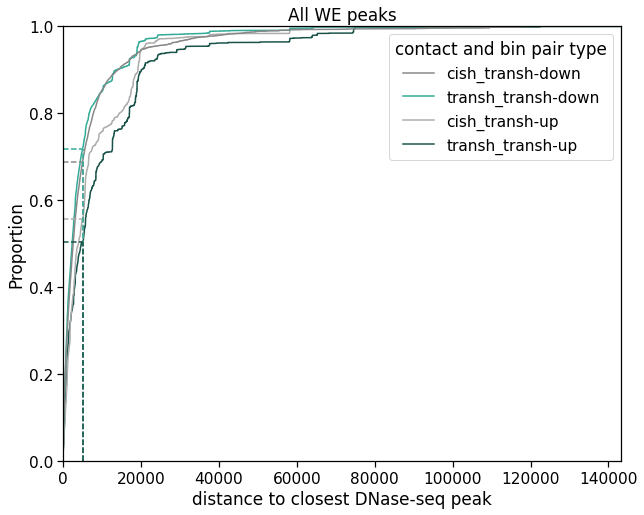

In [78]:
with sns.plotting_context('notebook', font_scale=1.4):
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    sns.ecdfplot(data = significant_pairs_closest_peak_WE, 
                 x = "distance to closest DNase-seq peak", 
                 hue = "contact and bin pair type",
                 palette = contact_type_palette,
                 ax = ax)
    ax.set_title("All WE peaks")
    for ct in ct_proportions_WE.keys():
        ax.plot((5000,5000), (0,ct_proportions_WE[ct]), color=contact_type_palette[ct], linestyle='dashed')
        ax.plot((0,5000), (ct_proportions_WE[ct],ct_proportions_WE[ct]), color=contact_type_palette[ct], linestyle='dashed')
    ax.set_xlim(0,max(significant_pairs_closest_peak_WE["distance to closest DNase-seq peak"]))
    plt.savefig(figures + "DNase_allWEpeaks_ECDFplot.svg", bbox_inches='tight')

## Area under ECDF for time points

In [79]:
def calc_ecdf_area(ax):
    # Get all the lines used to draw density curve 
    ecdf_lines = ax.get_lines()[-1]
    ecdf_x, ecdf_y = ecdf_lines.get_data()

    # Filter for height between 5 feet (60 inches) & 6 feet (72 inches)
    mask = (ecdf_x >= 0) & (ecdf_x <= 5) 
    filled_x, filled_y = ecdf_x[mask], ecdf_y[mask]
    area = np.trapz(filled_y, filled_x)
    area_scaled = area / 5
    return area_scaled

/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


2-4h_WE_peak 9.365096363770976e-33


/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


4-6h_WE_peak 2.5200499198675498e-30


/tmp/ipykernel_787405/1896993859.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


6-8h_WE_peak 1.0680246356602662e-22


/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


8-10h_WE_peak 1.2424039262226064e-19


/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


10-12h_WE_peak 2.0620473725518784e-24


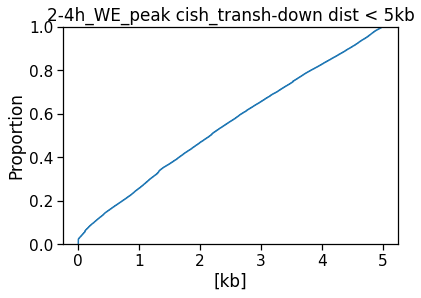

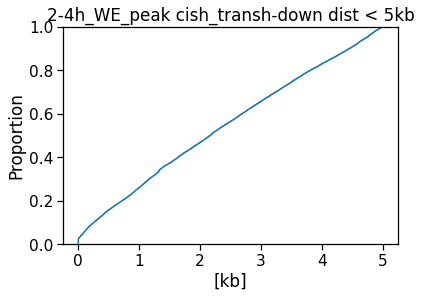

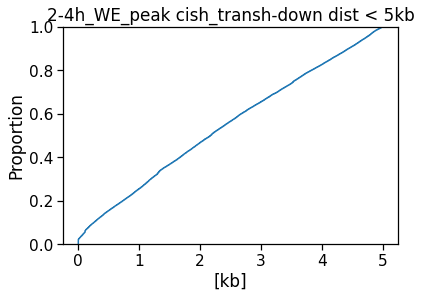

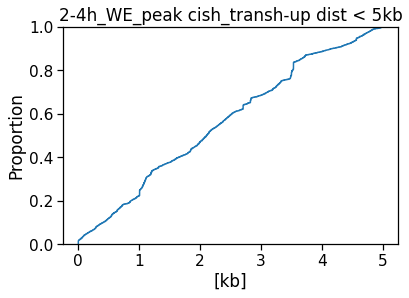

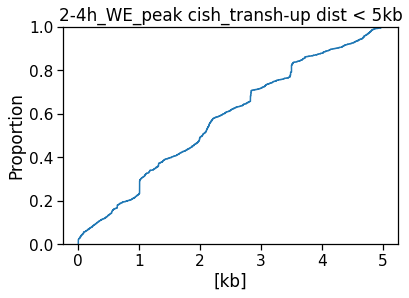

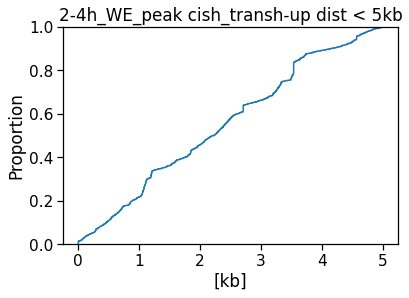

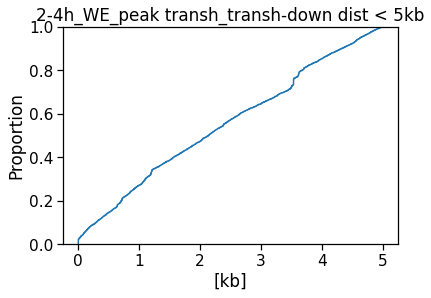

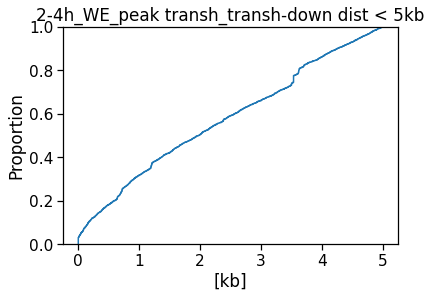

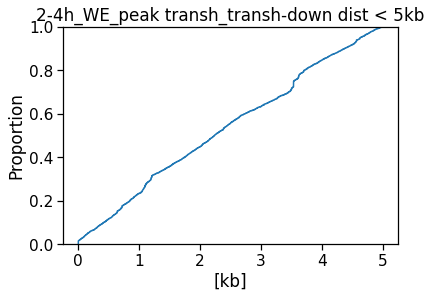

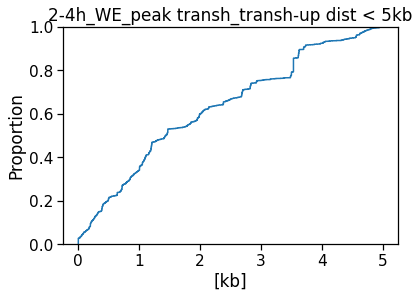

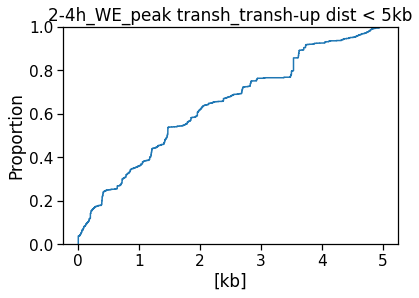

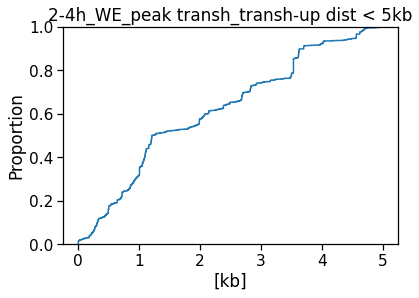

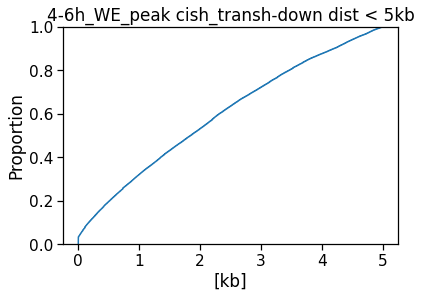

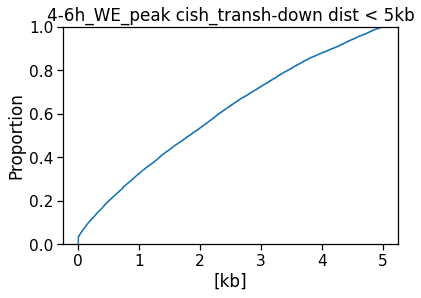

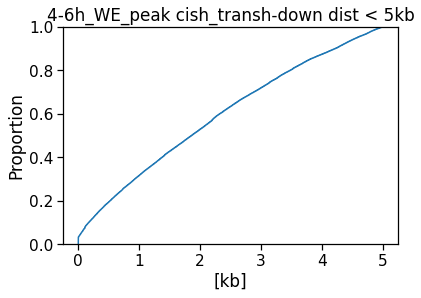

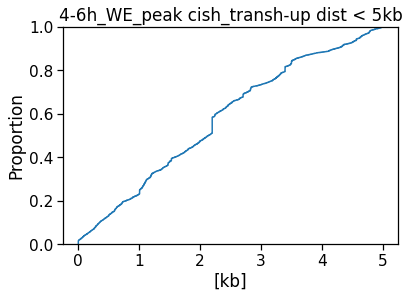

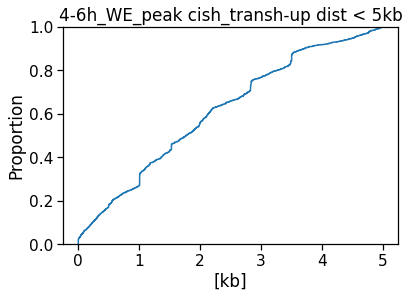

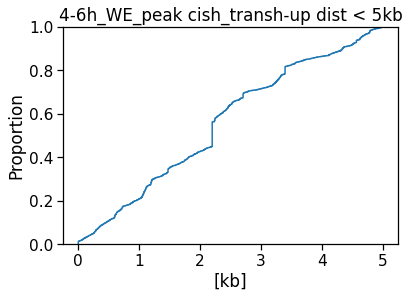

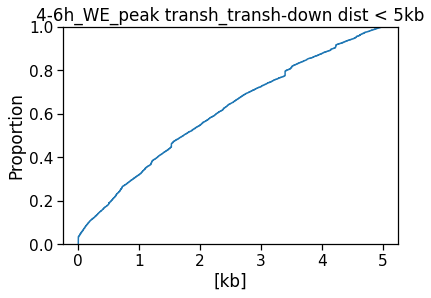

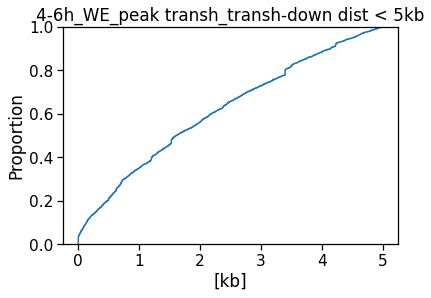

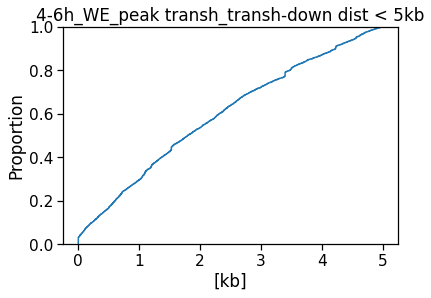

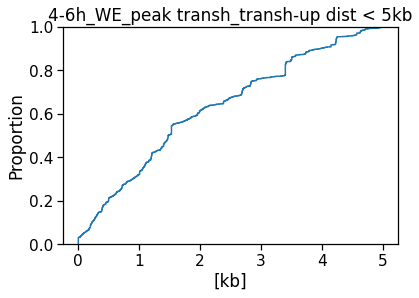

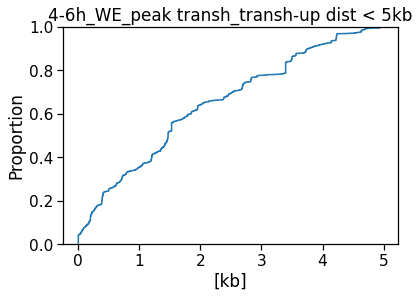

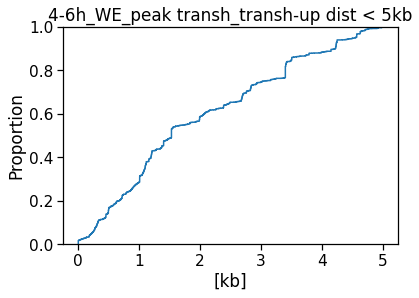

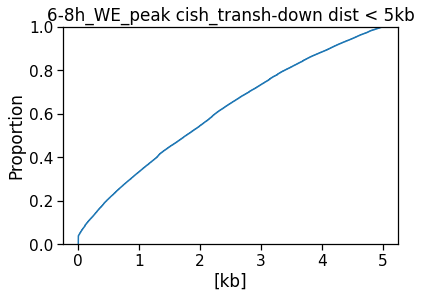

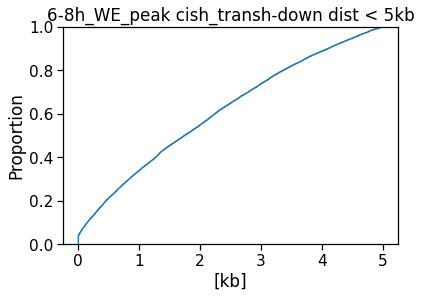

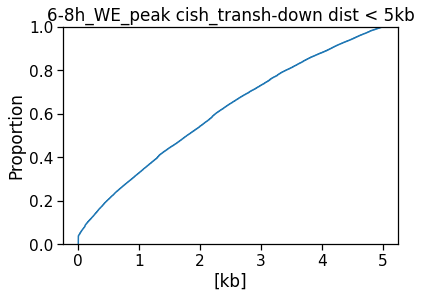

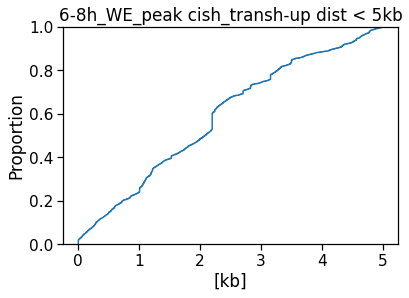

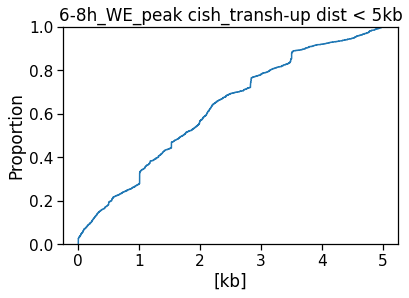

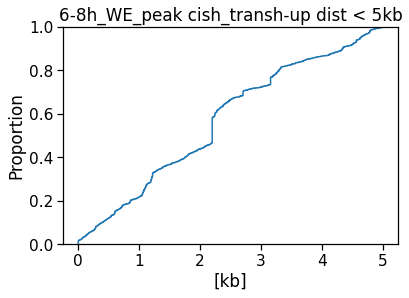

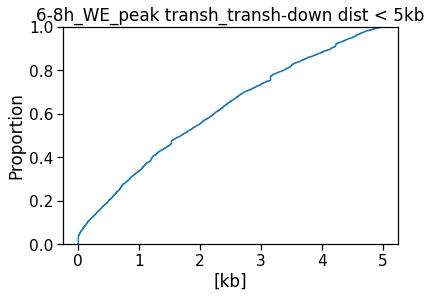

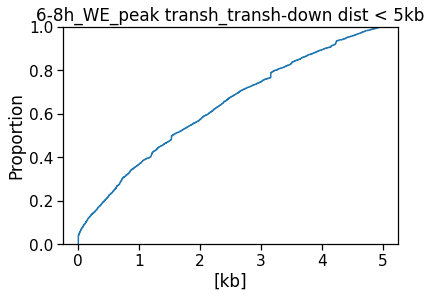

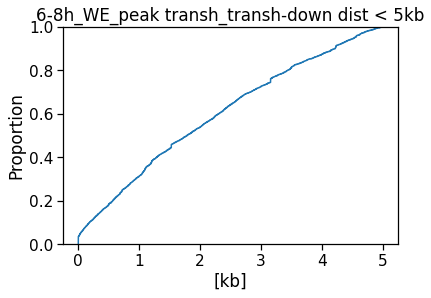

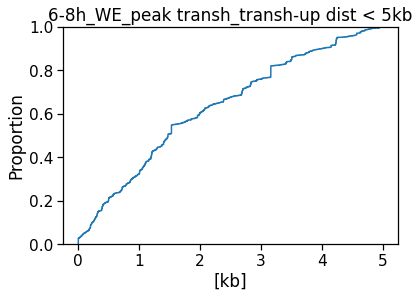

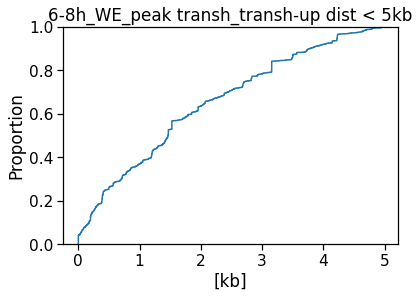

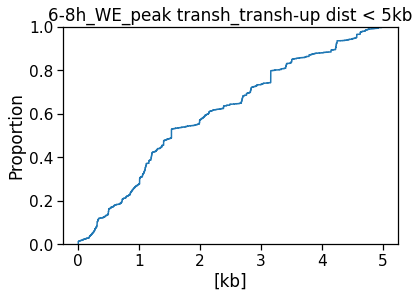

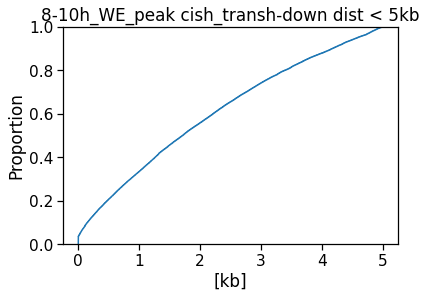

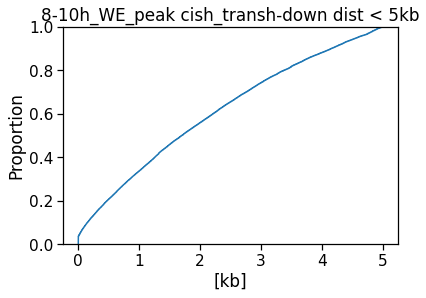

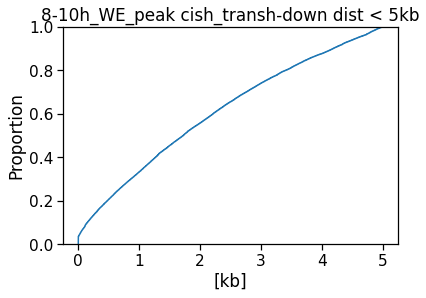

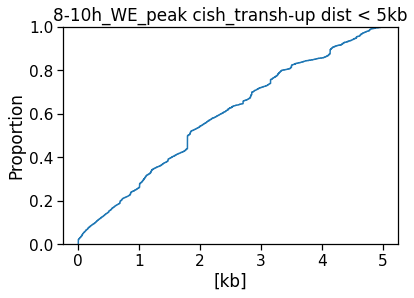

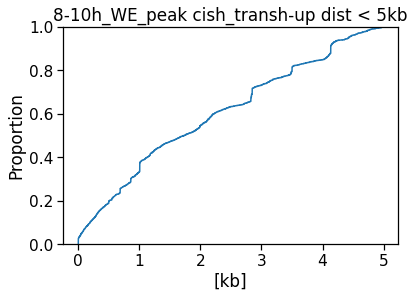

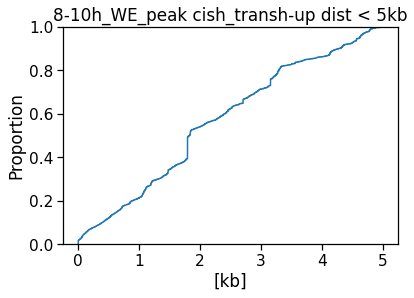

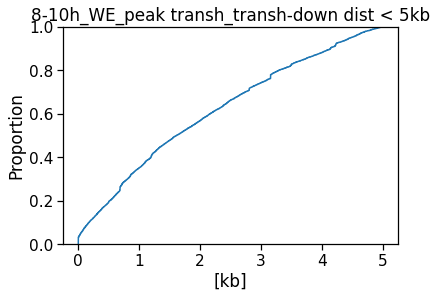

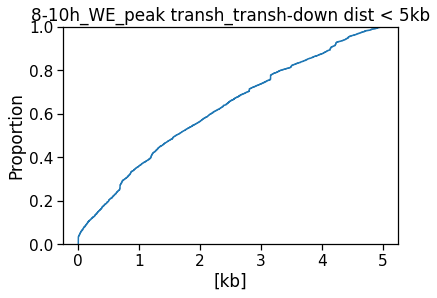

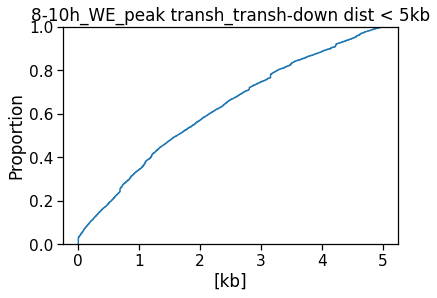

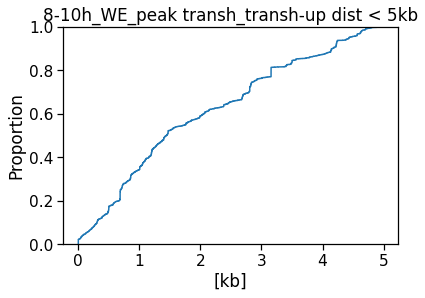

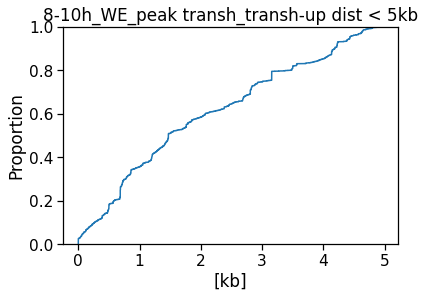

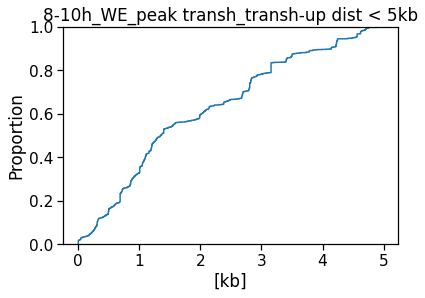

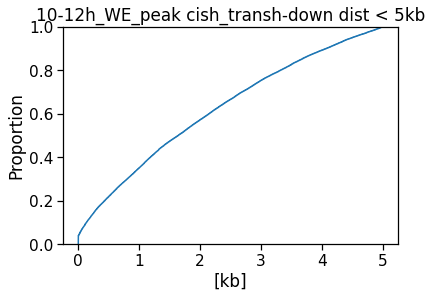

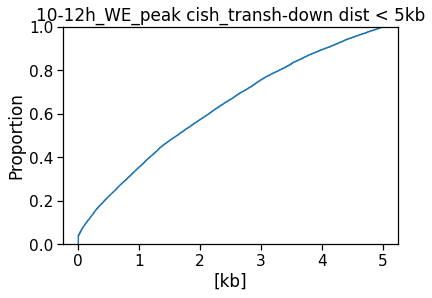

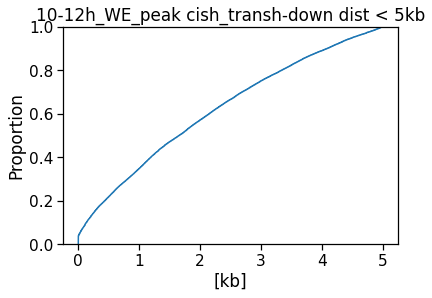

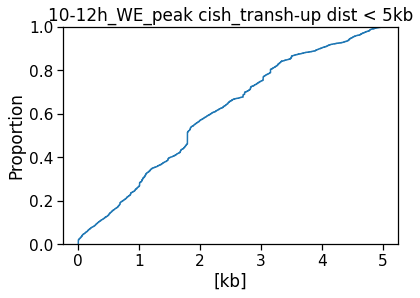

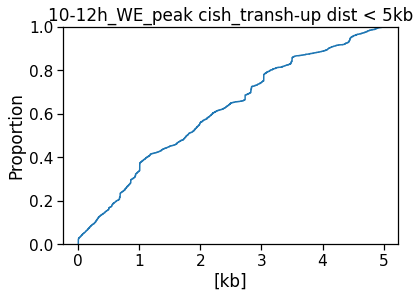

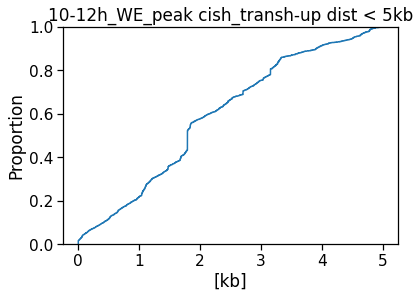

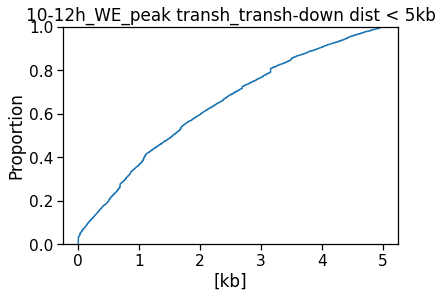

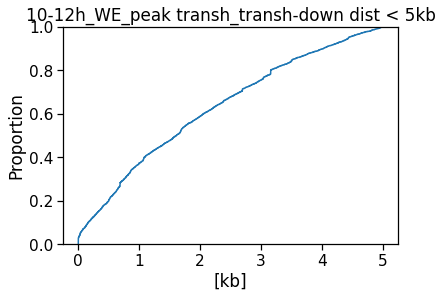

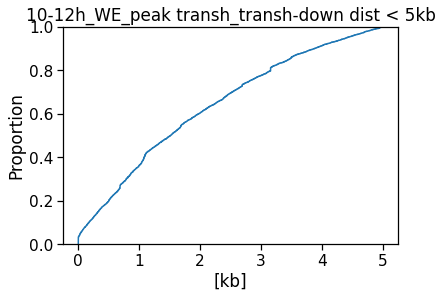

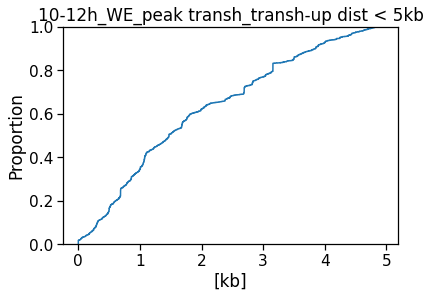

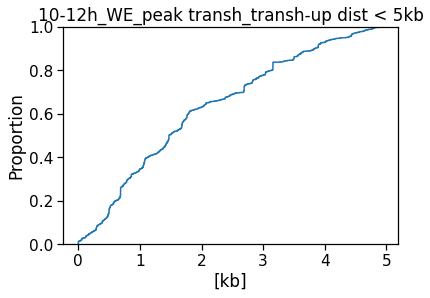

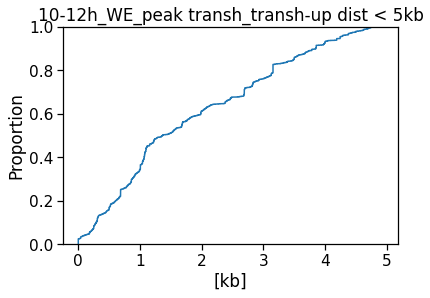

In [80]:
areas_dict = {"time point" : [],
              "contact type" : [],
              "bin pair type" : [],
              "area under ECDF curve" : [],
              "transh_transh-up vs cish_transh-up MWU p-value" : [],
              "num points" : []}

areas_dict_haplotypes = {"time point" : [],
              "contact type" : [],
              "bin pair type" : [],
              "haplotype" : [],
              "area under ECDF curve" : [],
              "num points" : []}

for d in ["2-4h_WE_peak", "4-6h_WE_peak", "6-8h_WE_peak", "8-10h_WE_peak", "10-12h_WE_peak"]:
    peaks = pbt.BedTool(DATA + "DNase-seq_Reddington2020/DHS_clusters_dm6_{}.gff".format(d))
    significant_pairs_closest_peak = find_dist_to_closest_peak(significant_pairs_long_filtered, peaks)

    significant_pairs_closest_peak["contact and bin pair type"] = significant_pairs_closest_peak["transh"].apply(lambda x: {True:"transh", False:"cish"}[x]) + "_" + significant_pairs_closest_peak["bin pair type"]
    significant_pairs_closest_peak = significant_pairs_closest_peak.rename(columns = {"distance to closest DNase-seq peak" : "distance to closest DNase-seq peak {}".format(d)})
    
    significant_pairs_closest_peak["distance to closest DNase-seq peak {} [kb]".format(d)] = significant_pairs_closest_peak["distance to closest DNase-seq peak {}".format(d)] / 1000
    
    below5kb = significant_pairs_closest_peak[significant_pairs_closest_peak["distance to closest DNase-seq peak {}".format(d)]<5000]
    
    s, p = stats.mannwhitneyu(below5kb[below5kb["contact and bin pair type"] == "transh_transh-up"]["distance to closest DNase-seq peak {}".format(d)], 
                              below5kb[below5kb["contact and bin pair type"] == "cish_transh-up"]["distance to closest DNase-seq peak {}".format(d)])
    print(d, p)
    
    contact_type_palette ={"transh_transh-up": "#185249", "cish_transh-down": "#888888", "cish_transh-up" : "#adadad", "transh_transh-down" : "#32ab98", "random" : "red"}
    
    
    contact_type_palette ={"transh_transh-up": "#185249", "cish_transh-down": "#888888", "cish_transh-up" : "#adadad", "transh_transh-down" : "#32ab98", "random" : "red"}


    for name, ct_group in below5kb.groupby("contact and bin pair type"):
        #all haplotypes
        with sns.plotting_context('notebook', font_scale=1.4):
            fig, ax = plt.subplots()


            sns.ecdfplot(data = ct_group, 
                     x = "distance to closest DNase-seq peak {} [kb]".format(d), 
                     #hue = "contact and bin pair type",
                     #palette = contact_type_palette,
                     ax = ax)
            ax.set_title("{} {} dist < 5kb".format(d, name))
            ax.set_xlabel("[kb]")

            area_scaled = calc_ecdf_area(ax)
            
            areas_dict["time point"].append(d)
            areas_dict["contact type"].append(name.split("_")[0])
            areas_dict["bin pair type"].append(name.split("_")[1])
            areas_dict["area under ECDF curve"].append(area_scaled)
            areas_dict["transh_transh-up vs cish_transh-up MWU p-value"].append(p)
            areas_dict["num points"].append(len(ct_group))
            
        #divided by haplotype
        for haplotype_name, haplotype_group in ct_group.groupby("haplotype"):
            with sns.plotting_context('notebook', font_scale=1.4):
                fig, ax = plt.subplots()


                sns.ecdfplot(data = haplotype_group, 
                         x = "distance to closest DNase-seq peak {} [kb]".format(d), 
                         #hue = "contact and bin pair type",
                         #palette = contact_type_palette,
                         ax = ax)
                ax.set_title("{} {} dist < 5kb".format(d, name))
                ax.set_xlabel("[kb]")

                area_scaled = calc_ecdf_area(ax)

                areas_dict_haplotypes["time point"].append(d)
                areas_dict_haplotypes["contact type"].append(name.split("_")[0])
                areas_dict_haplotypes["bin pair type"].append(name.split("_")[1])
                areas_dict_haplotypes["area under ECDF curve"].append(area_scaled)
                areas_dict_haplotypes["haplotype"].append(haplotype_name)
                areas_dict_haplotypes["num points"].append(len(haplotype_group))

In [81]:
areas_df = pd.DataFrame(areas_dict)
areas_df

,time point,contact type,bin pair type,area under ECDF curve,transh_transh-up vs cish_transh-up MWU p-value,num points
0,2-4h_WE_peak,cish,transh-down,0.547328,9.365096e-33,623189
1,2-4h_WE_peak,cish,transh-up,0.563411,9.365096e-33,10389
2,2-4h_WE_peak,transh,transh-down,0.554689,9.365096e-33,7091
3,2-4h_WE_peak,transh,transh-up,0.630376,9.365096e-33,3155
4,4-6h_WE_peak,cish,transh-down,0.598915,2.520050e-30,883243
5,4-6h_WE_peak,cish,transh-up,0.578138,2.520050e-30,13855
6,4-6h_WE_peak,transh,transh-down,0.604960,2.520050e-30,9765
7,4-6h_WE_peak,transh,transh-up,0.629750,2.520050e-30,3877
8,6-8h_WE_peak,cish,transh-down,0.609927,1.068025e-22,924943
9,6-8h_WE_peak,cish,transh-up,0.588831,1.068025e-22,13872


In [82]:
areas_haplotypes_df = pd.DataFrame(areas_dict_haplotypes)
areas_haplotypes_df.sort_values(by = "num points")

,time point,contact type,bin pair type,haplotype,area under ECDF curve,num points
7,2-4h_WE_peak,transh,transh-up,DGRP-57_transh,0.619941,1501
6,2-4h_WE_peak,transh,transh-up,DGRP-439_transh,0.639948,1654
15,4-6h_WE_peak,transh,transh-up,DGRP-57_transh,0.610915,1863
23,6-8h_WE_peak,transh,transh-up,DGRP-57_transh,0.607193,1905
22,6-8h_WE_peak,transh,transh-up,DGRP-439_transh,0.650792,1986
14,4-6h_WE_peak,transh,transh-up,DGRP-439_transh,0.646021,2014
31,8-10h_WE_peak,transh,transh-up,DGRP-57_transh,0.629099,2120
30,8-10h_WE_peak,transh,transh-up,DGRP-439_transh,0.610129,2439
39,10-12h_WE_peak,transh,transh-up,DGRP-57_transh,0.625760,2551
38,10-12h_WE_peak,transh,transh-up,DGRP-439_transh,0.625445,2848


/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cish_cish vs. transh_transh: p = 9e-33


/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cish_cish vs. transh_transh: p = 3e-30


/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cish_cish vs. transh_transh: p = 1e-22


/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cish_cish vs. transh_transh: p = 1e-19


/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/magda/miniconda3/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cish_cish vs. transh_transh: p = 2e-24


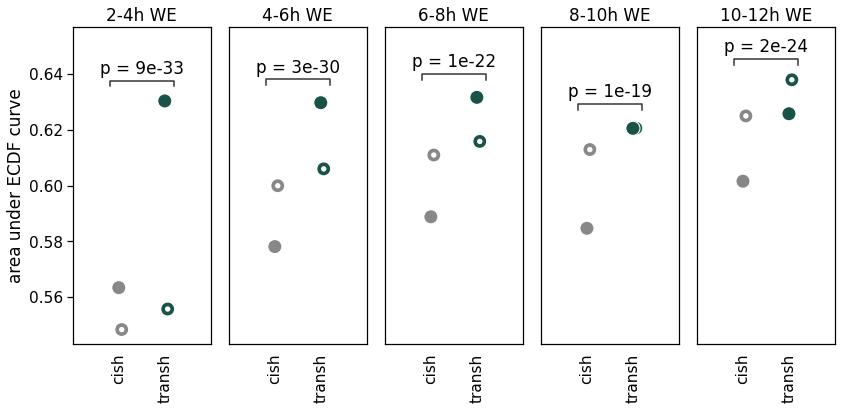

In [83]:
datapoints = ["2-4h_WE_peak", "4-6h_WE_peak", "6-8h_WE_peak", "8-10h_WE_peak", "10-12h_WE_peak"]
n = len(datapoints)
areas_df_DOWN = areas_df[areas_df["bin pair type"].str.contains("transh-down")]
areas_df_UP = areas_df[areas_df["bin pair type"].str.contains("transh-up")]

contact_type_palette ={"transh": "#185249", "cish": "#888888"}
pairs = [(("cish", "cish"),("transh", "transh"))]

counter = 0
         
with sns.plotting_context('notebook', font_scale=1.4): 
    
    fig, axes = plt.subplots(ncols=n, sharex=True, sharey=True, figsize = (12,6))

    for ax, time in zip(axes, datapoints):
        grp2 = areas_df_DOWN[areas_df_DOWN["time point"] == time]
        
        plot_params2 = {
            'data' : grp2,
            'x' : "contact type",
            'y' :  "area under ECDF curve",
            'palette' : contact_type_palette,
            'hue' : "contact type"
        }
        
        sns.scatterplot(marker="$\circ$", s=300, ec="face", ax = ax, **plot_params2)  
        
        grp1 = areas_df_UP[areas_df_UP["time point"] == time]         
        
        plot_params1 = {
            'data' : grp1,
            'x' : "contact type",
            'y' :  "area under ECDF curve",
            'palette' : contact_type_palette,
            'hue' : "contact type"
        }
        
        sns.scatterplot(s=200, ax = ax, **plot_params1)
        
        pvalues = [grp1["transh_transh-up vs cish_transh-up MWU p-value"].values[0]]
        formatted_pvalues = ["p = {:.0e}".format(p) for p in pvalues] 
         
        annotator = Annotator(ax, pairs, **plot_params1) 
        annotator.configure(text_offset=3)
        annotator.set_custom_annotations(formatted_pvalues).annotate()     
 
        
        ax.set_title(" ".join(time.split("_")[:-1]))
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlim(-1,2)
        ax.set_xlabel("")
        ax.get_legend().set_visible(False)
        ax.tick_params(bottom=False)
        
        if counter > 0:
            ax.tick_params(left=False)          
            
        counter += 1


    plt.tight_layout()
    plt.savefig(figures + "DNase_WEpeaks_areaECDF.svg", bbox_inches='tight')

## Divide by haplotypes

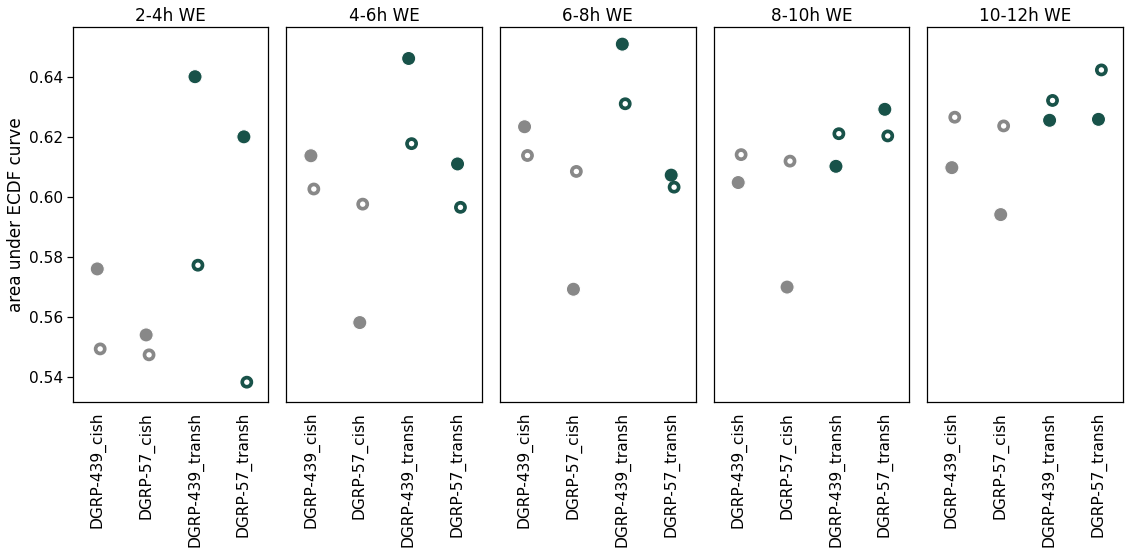

In [84]:
datapoints = ["2-4h_WE_peak", "4-6h_WE_peak", "6-8h_WE_peak", "8-10h_WE_peak", "10-12h_WE_peak"]
n = len(datapoints)
areas_haplotypes_df_DOWN = areas_haplotypes_df[areas_haplotypes_df["bin pair type"].str.contains("transh-down")]
areas_haplotypes_df_UP = areas_haplotypes_df[areas_haplotypes_df["bin pair type"].str.contains("transh-up")]
contact_type_palette ={"transh": "#185249", "cish": "#888888"}
counter = 0
haplotypes_order = ['DGRP-57_cis', 'DGRP-439_cis', 'DGRP-57_trans', 'DGRP-439_trans']
with sns.plotting_context('notebook', font_scale=1.4): 
    
    fig, axes = plt.subplots(ncols=n, sharex=True, sharey=True, figsize = (16,8))

    for ax, time in zip(axes, datapoints):
        grp1 = areas_haplotypes_df_UP[areas_haplotypes_df_UP["time point"] == time].copy()
        sns.scatterplot(data = grp1, x = "haplotype", y = "area under ECDF curve", hue = "contact type", palette = contact_type_palette, s=200, ax = ax)

        grp2 = areas_haplotypes_df_DOWN[areas_haplotypes_df_DOWN["time point"] == time]
        sns.scatterplot(data = grp2, x = "haplotype", y = "area under ECDF curve", hue = "contact type", palette = contact_type_palette, marker="$\circ$", s=300, ec="face", ax = ax)
        
        ax.set_title(" ".join(time.split("_")[:-1]))
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlim(-0.5,3.5)
        ax.set_xlabel("")
        ax.get_legend().set_visible(False)
        ax.tick_params(bottom=False)
        
        if counter > 0:
            ax.tick_params(left=False)          
            
        counter += 1

    #plt.show()
    plt.tight_layout()
    plt.savefig(figures + "DNase_WEpeaks_areaECDF_by_haplotype.svg", bbox_inches='tight')